In [ ]:
!pip install pyspark

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pandas as pd

In [ ]:
spark = SparkSession.builder.appName("Healthcare_Analysis").getOrCreate()

In [ ]:
files = [
    "1) Jan-June 2022-unlock.xlsx", "2 July-Sep 2022-unlock.xlsx",
    "3) Oct-Dec 2022 - unlock.xlsx", "4 Jan-March 2023-unlock.xlsx",
    "5) April-June-2023 - unlock.xlsx", "6) July-2023 unlock.xlsx",
    "7) Aug-Sep-2023 unlock.xlsx", "8) Oct-Dec-2023 unlock.xlsx",
    "9)Jan-March-2024 unlock.xlsx", "10) April-June-2024 unlock.xlsx",
    "11) July-Sep-2024 unlock.xlsx", "12) Oct-Dec-2024 unlock.xlsx",
    "13)Jan-April-2025 unlock.xlsx"
]

In [ ]:
dataframes = []
for f in files:
    p = pd.read_excel(f)
    p["رقم التسجيل"] = p["رقم التسجيل"].astype("Int64").astype(str)
    s = spark.createDataFrame(p)
    dataframes.append(s)

In [ ]:
standard_columns = dataframes[0].columns
combined = dataframes[0]
for df in dataframes[1:]:
    aligned = df.select(*[col if col in df.columns else lit(None).alias(col) for col in standard_columns])
    combined = combined.unionByName(aligned)
combined.cache()

DataFrame[Unnamed: 0: double, رقم التسجيل: string, Unnamed: 2: double, Unnamed: 3: double, Unnamed: 4: double, Unnamed: 5: double, Unnamed: 6: double, تاريخ الزيارة: string, Unnamed: 8: double, Unnamed: 9: double, Unnamed: 10: double, Unnamed: 11: double, نتائج: string, تعليقات: string]

In [ ]:
#4renaming columns and convert the date string to a timestamp
df_selected = combined.select(
    col("رقم التسجيل").alias("VisitNumber"),
    col("تاريخ الزيارة").alias("RawColumn"),
    col("نتائج").alias("TestResult")
).withColumn("VisitDateTime", to_timestamp("RawColumn", "yyyy-MM-dd HH:mm:ss"))

#forwardfill the VisitDateTime column
window_spec = Window.orderBy().rowsBetween(Window.unboundedPreceding, 0)
df_selected = df_selected.withColumn("VisitDateTime", last("VisitDateTime", ignorenulls=True).over(window_spec))

#filter out rows where RawColumn is equal to VisitDateTime (i.e., not a test name)
df_only_tests = df_selected.filter(col("RawColumn") != col("VisitDateTime").cast("string"))

#select and rename columns
df_structured = df_only_tests.select(
    col("VisitNumber").cast("string"),
    "VisitDateTime",
    col("RawColumn").alias("TestName"),
    "TestResult"
)

#remove invalid or missing entries
df_final = df_structured.filter(
    col("VisitNumber").isNotNull() & ~col("VisitNumber").rlike("^NaN$") &
    col("TestName").isNotNull() & ~col("TestName").rlike("^NaN$") &
    col("TestResult").isNotNull() & ~col("TestResult").rlike("^NaN$")
)

#cache and ssample output
df_final.cache()
df_final.show(10, truncate=False)

+------------+-------------------+-----------------------------+------------------------------------------+
|Visit Number|Visit DateTime     |Test Name                    |Result                                    |
+------------+-------------------+-----------------------------+------------------------------------------+
|22012       |2022-04-16 20:50:46|Respiratory Profile By RT-PCR|SARS-COV2 (COVID19) By RT-PCR: Negative   |
|22013       |2022-04-23 08:41:19|Respiratory Profile By RT-PCR|SARS-COV2 (COVID19) By RT-PCR: Negative   |
|22014       |2022-04-26 20:44:22|Respiratory Profile By RT-PCR|SARS-COV2 (COVID19) By RT-PCR: Negative   |
|22015       |2022-04-26 22:11:36|Respiratory Profile By RT-PCR|SARS-COV2 (COVID19)  RT-PCR: Negative ,   |
|22016       |2022-04-26 22:13:48|Respiratory Profile By RT-PCR|SARS-COV2 (COVID19)  RT-PCR: Negative ,   |
|22017       |2022-05-02 17:21:56|Respiratory Profile By RT-PCR|SARS-COV2 (COVID19)  RT-PCR: Negative  ,  |
|22018       |2022-05-03 17:

# **Scenario 1**

In [ ]:
top = df_final.groupBy("Test Name").count().orderBy("count", ascending=False)
top_pd = top.toPandas().head(10)

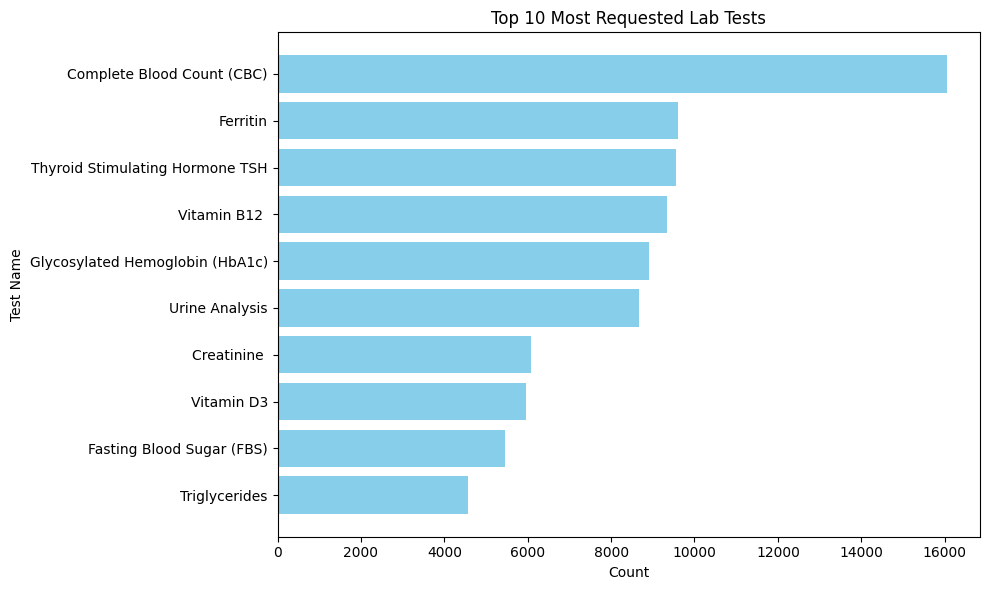

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(top_pd["Test Name"], top_pd["count"], color="skyblue")
plt.xlabel("Count")
plt.ylabel("Test Name")
plt.title("Top 10 Most Requested Lab Tests")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

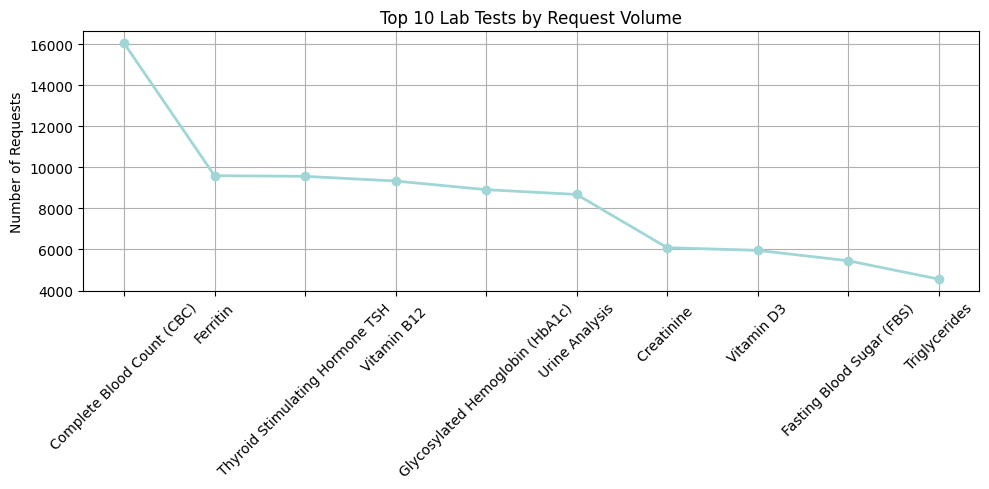

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(top_pd["Test Name"], top_pd["count"], marker='o', color="#A0D6D6", linewidth=2)
plt.title("Top 10 Lab Tests by Request Volume")
plt.xticks(rotation=45)
plt.ylabel("Number of Requests")
plt.grid(True)
plt.tight_layout()
plt.show()

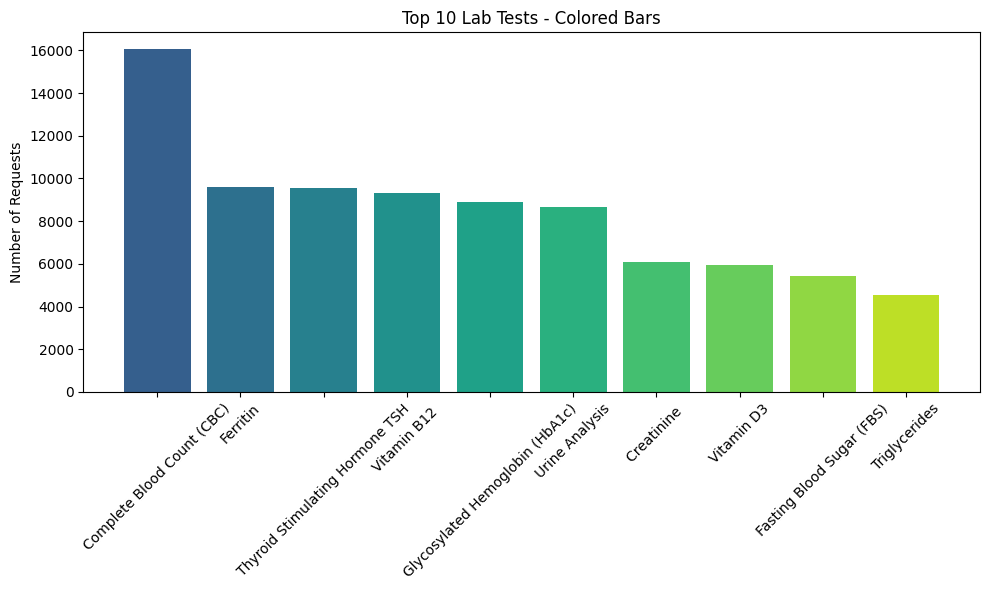

In [ ]:
plt.figure(figsize=(10, 6))
bars = plt.bar(top_pd["Test Name"], top_pd["count"], color=plt.cm.viridis(np.linspace(0.3, 0.9, 10)))
plt.title("Top 10 Lab Tests - Colored Bars")
plt.ylabel("Number of Requests")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Scenario 2**

In [ ]:
monthly = df_final.withColumn("Month", date_format("Visit DateTime", "yyyy-MM"))
monthly_trend = monthly.groupBy("Month").count().orderBy("Month")
monthly_trend_pd = monthly_trend.toPandas()
monthly_trend_pd["Month"] = pd.to_datetime(monthly_trend_pd["Month"], format="%Y-%m")

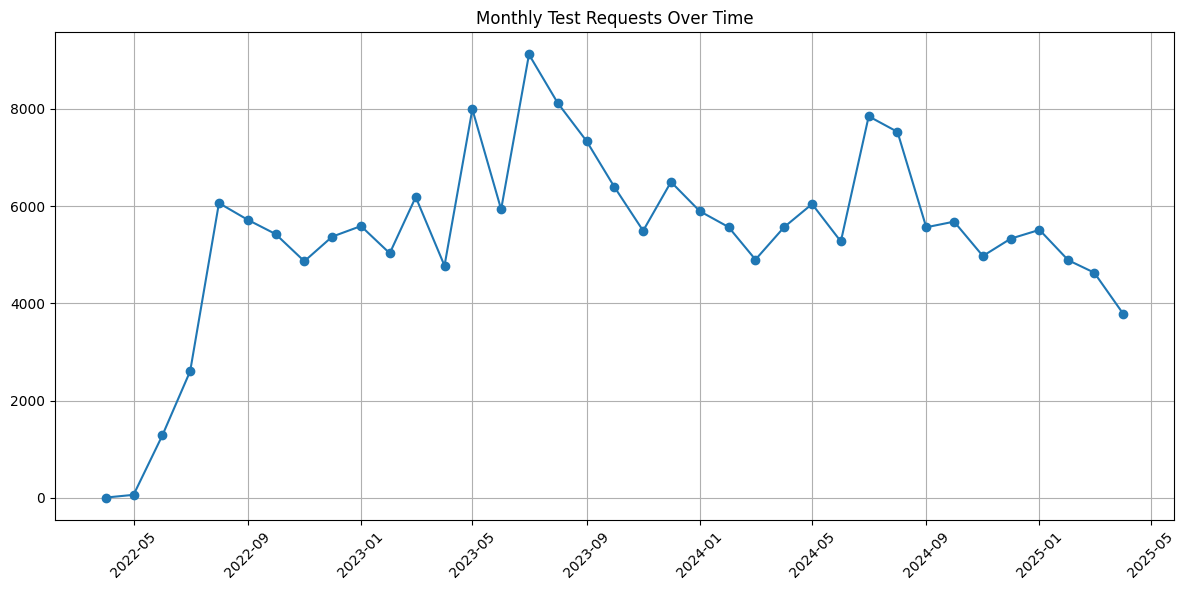

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_trend_pd["Month"], monthly_trend_pd["count"], marker='o')
plt.title("Monthly Test Requests Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Scenario 8**

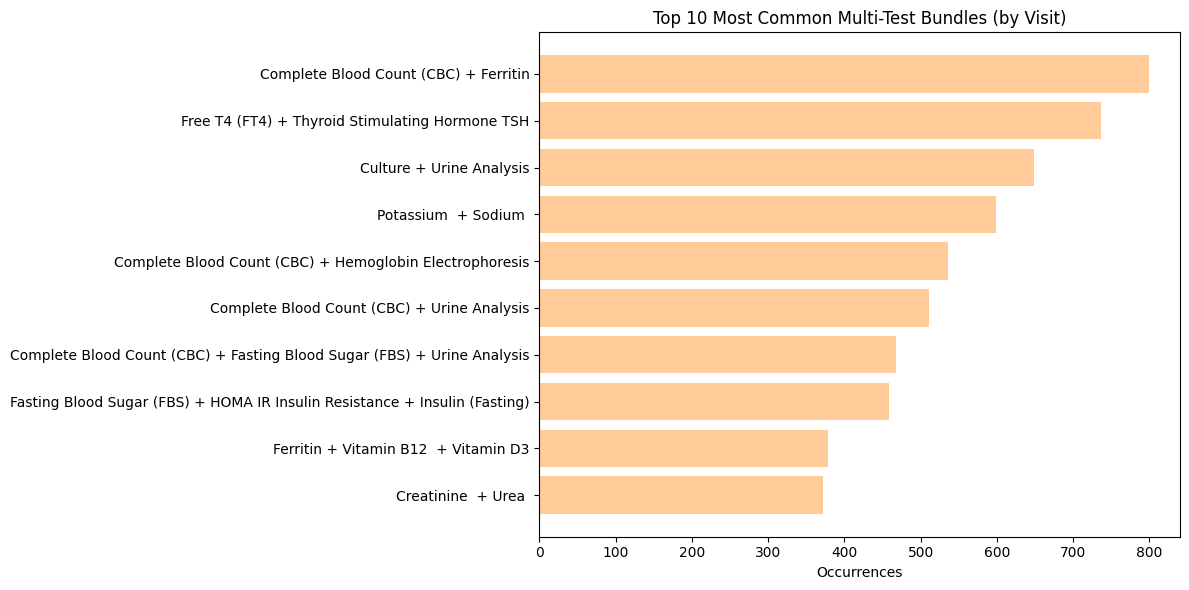

In [ ]:
from pyspark.sql.functions import collect_set, concat_ws, sort_array, size

#group by visit and collect tests as sets
df_bundles = df_final.groupBy("Visit Number") \
    .agg(collect_set("Test Name").alias("Test Bundle"))

#filter out single test visits
df_bundles = df_bundles.filter(size("Test Bundle") > 1)

# convert test sets into sorted readable bundle strings
df_bundles = df_bundles.withColumn("Bundle Key", concat_ws(" + ", sort_array("Test Bundle")))

# countinf bundle occurrences
df_bundle_counts = df_bundles.groupBy("Bundle Key") \
    .count().orderBy("count", ascending=False)

# convert to pandas
df_bundle_counts_pd = df_bundle_counts.toPandas().head(10)

# plot
plt.figure(figsize=(12, 6))
plt.barh(df_bundle_counts_pd["Bundle Key"], df_bundle_counts_pd["count"], color="#FFCC99")
plt.xlabel("Occurrences")
plt.title("Top 10 Most Common Multi-Test Bundles (by Visit)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# **Scenario 4**

In [ ]:
df_pd = df_final.toPandas()
df_pd["Visit DateTime"] = pd.to_datetime(df_pd["Visit DateTime"])

In [ ]:
# add a season column to the original df
df_pd["Month"] = df_pd["Visit DateTime"].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df_pd["Season"] = df_pd["Month"].map(get_season)

# group by season and test name
seasonal_test_counts = df_pd.groupby(["Season", "Test Name"]).size().reset_index(name="Count")

# filter top  tests per season
top_seasonal_tests = seasonal_test_counts.groupby("Season").apply(
    lambda x: x.sort_values("Count", ascending=False).head(5)
).reset_index(drop=True)

# palette
season_colors = {
    "Winter": "#00BFFF",  # Deep Sky Blue
    "Spring": "#32CD32",  # Lime Green
    "Summer": "#FFD700",  # Gold
    "Autumn": "#FF6347"   # Tomato Red
}


<ipython-input-24-2395847337>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_seasonal_tests = seasonal_test_counts.groupby("Season").apply(


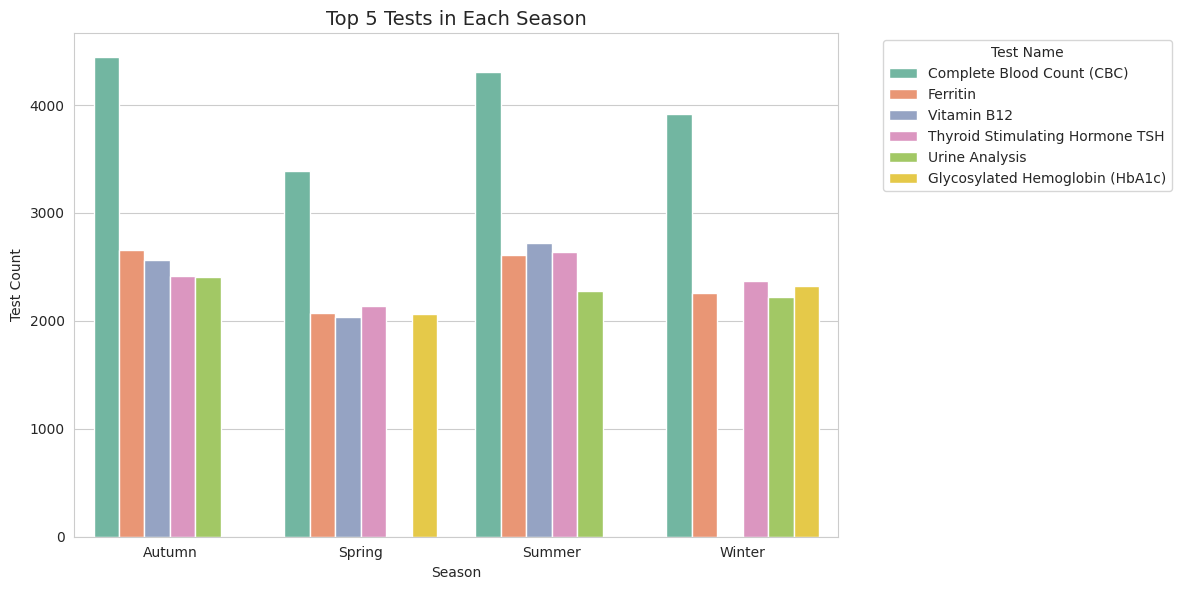

In [ ]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(data=top_seasonal_tests, x="Season", y="Count", hue="Test Name", palette="Set2")

plt.title("Top 5 Tests in Each Season", fontsize=14)
plt.xlabel("Season")
plt.ylabel("Test Count")
plt.legend(title="Test Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
df_final.toPandas().to_csv("cleaned_healthcare_data.csv", index=False)